# EXPLORATION CLUSTERING CROISE KMEANS / CAH #

Dans un autre notebook, on a pu observer une forte corrélation entre l'activité des entreprises et le salaire moyen des communes : 

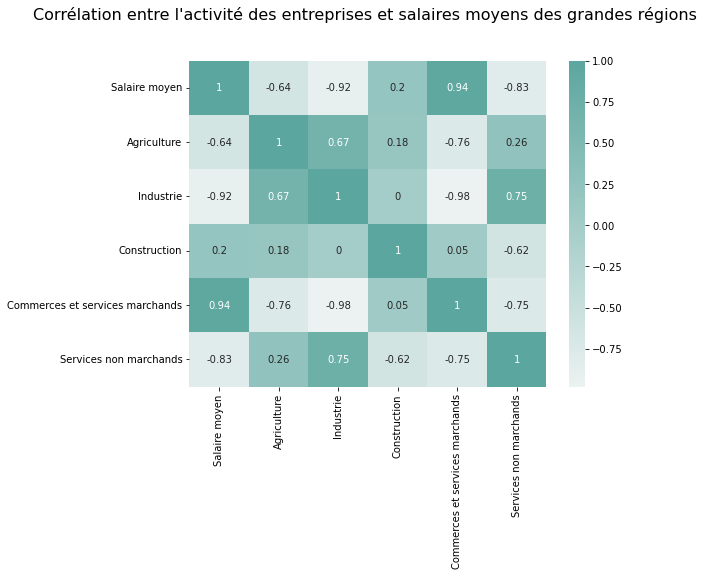

On tente dans ce notebook d'établir à partir des données d'activité de catégoriser le niveau de salaire de chaque commune, la majorité des salaires de notre jeu de données étant manquants de par le secret statistique de l'INSEE

## IMPORT DE LIBRAIRIES ##

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

## IMPORT DES DONNEES ET CHOIX DES VARIABLES ##

### Choix des variables ###

- Variables géographiques:
    - CODGEO
- Variables entreprises:
    - ETTOT20 Total Ets actifs fin 2020	
    - ETAZ20 Ets actifs agriculture fin 2020	
    - ETBE20 Ets actifs industrie fin 2020	
    - ETFZ20 Ets actifs construction fin 2020	
    - ETGU20 Ets actifs commerce et services marchands fin 2020	
    - ETOQ20 Ets actifs services non marchands fin 2020	
- Variables salaires
    - SNHM20 Salaire net horaire moyen en 2020

### Import et mise en forme ###

In [2]:
df = pd.read_csv('../all_content_2020_v4.csv')

C:\Users\vivie\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1,4,8,519,520,521) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
#Constitution du nouveau dataset suite au choix des variables

df_analyse = df[['CODGEO', 
               'ETTOT20', 
               'ETAZ20', 
               'ETBE20', 
               'ETFZ20', 
               'ETGU20', 
               'ETOQ20', 
               'SNHM20']]


In [4]:
df_analyse.columns=['CODGEO', 'TOTAL_ETS', 'AGRI', 'INDUS', 'CONST', 'COM_SER', 'SER', 'SALAIREM']

In [5]:
# Supression des lignes ayant des NaN sur la variable ETTOT20

df_analyse = df_analyse.dropna(subset=['TOTAL_ETS'], axis=0).reset_index(drop=True)

In [6]:
df_analyse.columns[2:-1]

Index(['AGRI', 'INDUS', 'CONST', 'COM_SER', 'SER'], dtype='object')

In [7]:
for i in df_analyse.columns[2:-1]:
    df_analyse['%' + i] = np.round(df_analyse[i] / df_analyse['TOTAL_ETS'] * 100, 2)
    df_analyse = df_analyse.drop(i, axis=1)

In [8]:
df_analyse = df_analyse.drop('TOTAL_ETS', axis=1)

In [9]:
df_analyse.head()

,CODGEO,SALAIREM,%AGRI,%INDUS,%CONST,%COM_SER,%SER
0,1001,NaN,14.29,0.00,21.43,50.00,14.29
1,1002,NaN,25.00,0.00,0.00,50.00,25.00
2,1004,15.013132,0.17,5.29,9.90,69.97,14.68
3,1005,NaN,4.35,8.70,21.74,50.00,15.22
4,1006,NaN,0.00,0.00,0.00,50.00,50.00


In [10]:
df_analyse.isna().sum()

CODGEO          0
SALAIREM    29562
%AGRI         108
%INDUS        109
%CONST        108
%COM_SER      108
%SER          108
dtype: int64

### Division du dataset pour les besoins du clustering ###

In [11]:
# Création d'un dataset avec salaires uniquement :
df_salaires = df_analyse.dropna(subset=['SALAIREM'], axis=0).reset_index(drop=True)

In [12]:
# Création d'un dataset sans salaires uniquement :
df_ss_salaires = df_analyse[df_analyse['SALAIREM'].isna()].reset_index(drop=True)
df_ss_salaires = df_ss_salaires.drop('SALAIREM', axis=1)

In [13]:
print("Nombre de samples avec salaires :", len(df_salaires))
print("Nombre de samples sans salaires :", len(df_ss_salaires))

Nombre de samples avec salaires : 5376
Nombre de samples sans salaires : 29562


## CATEGORISATION DES COMMUNES PAR SALAIRE : PREPARATION DE LA TARGET ##

Ce projet de clustering porte sur le fait de classifier les communes en fonction de leur salaire moyen.  
Il faut donc commencer par catégoriser le dataset disposant de salaires pour obtenir un dataframe "target".  
On détermine ici 5 catégories :

- très bas
- bas
- moyen
- bon
- très bon

In [14]:
df_salaires['classes'] = pd.qcut(df_salaires['SALAIREM'], q=3, labels=['bas', 'moyen', 'bon'])

In [15]:
df_salaires.groupby('classes').agg(salaire_moyen = ('SALAIREM', 'mean'))

,salaire_moyen
classes,
bas,13.104648
moyen,14.648633
bon,18.392206


**On peut désormais constituer notre dataframe target :**

In [16]:
x_test = df_salaires.drop(['CODGEO','classes', 'SALAIREM'], axis=1)
target = df_salaires[['CODGEO', 'SALAIREM', 'classes']]

## PRE-PROCESSING DES SAMPLES ##

Les samples que l'on cherche à catégoriser se trouvent dans le dataframe sans salaires.  
Les variables ont déjà été normalisées dans l'étape précédente

In [17]:
#On créé un dataframe feats avec les données numériques
feats = x_test.select_dtypes('number')

In [18]:
feats.head()

,%AGRI,%INDUS,%CONST,%COM_SER,%SER
0,0.17,5.29,9.90,69.97,14.68
1,5.88,16.18,16.18,47.06,14.71
2,0.44,23.14,6.99,63.32,6.11
3,1.25,10.00,15.00,65.00,8.75
4,31.67,11.67,20.00,28.33,8.33


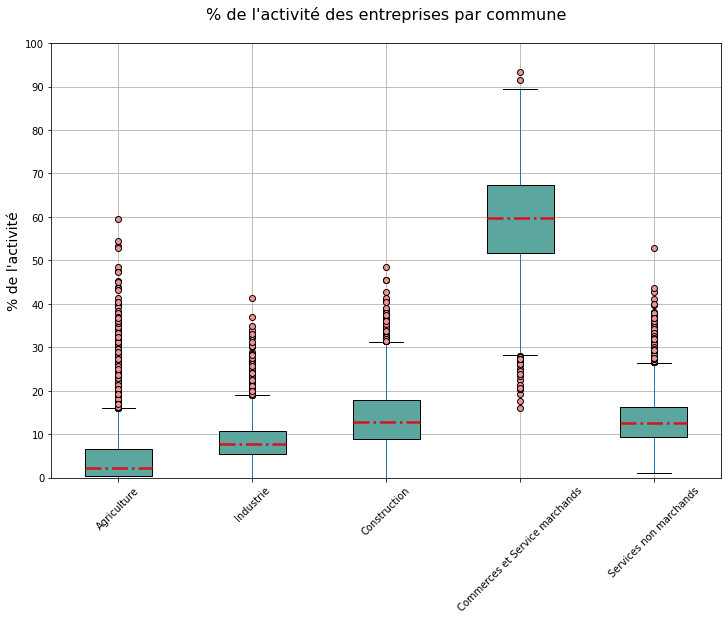

In [19]:
flierprops = dict(marker=".", markerfacecolor="#F29494", markersize=12)
medianprops = dict(linestyle='-.', linewidth=2.5, color="#D91122")
boxprops=dict(facecolor='#5BA69E')

plt.figure(figsize=(12,8))
feats.boxplot(patch_artist=True,boxprops=boxprops, medianprops=medianprops, flierprops=flierprops )
plt.xticks([1,2,3,4,5],['Agriculture', 'Industrie', 'Construction', 'Commerces et Service marchands', 'Services non marchands'], rotation=45)
plt.ylabel("% de l'activité", fontsize=14)
plt.yticks(np.linspace(0,100,11))
plt.ylim(0,100)
plt.title("% de l'activité des entreprises par commune\n", fontsize=16)
plt.show()

## CLUSTERING KMEANS ##

In [20]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=50) #on définit volontairement un grand nombre de clusters pour traiter ensuite les centroides dans une CAH
kmeans.fit(feats)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

C:\Users\vivie\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Création d'un Dendrogram des centroïdes  ###

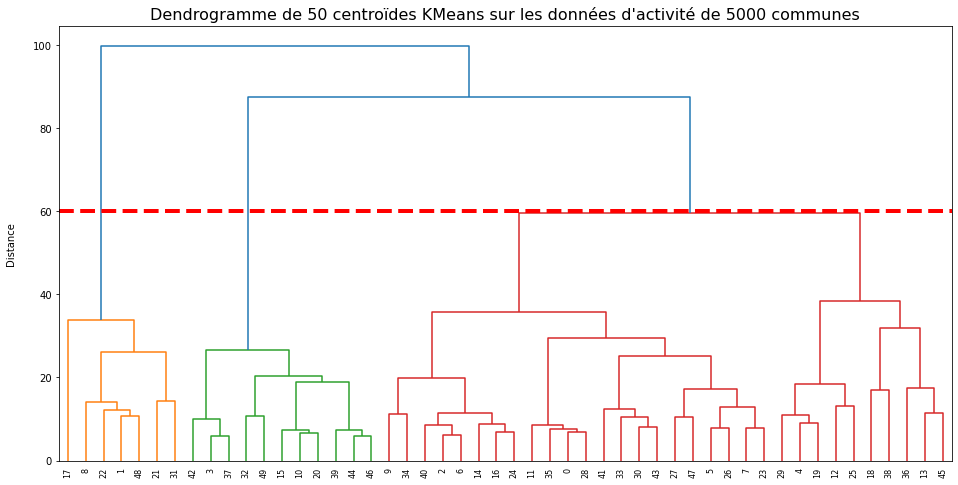

In [21]:
from scipy.cluster.hierarchy import linkage, dendrogram
Z = linkage(centroids, method='ward', metric='euclidean')
plt.figure(figsize=(16,8))
dendrogram(Z)
plt.axhline(linestyle='--', y=60, color='r', lw=4)
plt.title("Dendrogramme de 50 centroïdes KMeans sur les données d'activité de 5000 communes", fontsize=16)
plt.ylabel('Distance \n')
plt.show()

Le Dendrogram suggere plutôt 3 clusters. On stocke le nombre de clusters dans une variable

In [22]:
opt_clusters = 3

## CLASSIFICATION ASCENDANTE HIERARCHIQUE DES CENTROIDES KMEANS ##

In [23]:
from sklearn.cluster import AgglomerativeClustering

CAH = AgglomerativeClustering(n_clusters=opt_clusters)
CAH.fit(centroids)
labels_CAH = CAH.labels_

On dispose désormais de labels KMEANS pour 50 clusters et de labels CAH Pour 3 clusters  

In [24]:
print('Nombre de labels KMeans :', np.size(labels))
print('Nombre de labels CAH :', np.size(labels_CAH))

Nombre de labels KMeans : 5376
Nombre de labels CAH : 50


Il nous faut pourvoir attribuer les labels CAH à l'ensemble du jeu de données initial.

In [25]:
#Ajout d'une colonne avec les labels KMEANS au dataset
feats['labels_KMEANS'] = labels

#Création d'un dataset avec les centroides KMEANS
centroids_df = pd.DataFrame(centroids, columns=['%AGRI', '%INDUS', '%CONST', '%COM_SER', '%SER'])

#Ajout de la classification CAH au dataframe centroids:
centroids_df['labels_CAH'] = labels_CAH

#Groupby du dataset initial par la classification KMEANS aggrégé par la moyenne
feats_groupby = feats.groupby('labels_KMEANS', as_index=False)['%AGRI', '%INDUS', '%CONST', '%COM_SER', '%SER'].mean()

#Centroids_df et feats_groupby sont désormais identiques en termes de variables numériques et dans le même ordre
#On peut donc créér un dictionnaire des labels KMEANS / CAH
cluster_dict = dict(list(zip(feats_groupby['labels_KMEANS'], centroids_df['labels_CAH'])))

#On ajoute désormais la classification CAH au dataset initial
feats['labels_CAH'] = feats['labels_KMEANS'].map(cluster_dict)

feats['labels_CAH'].value_counts(dropna=False)

C:\Users\vivie\AppData\Local\Temp/ipykernel_4216/3255189743.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  feats_groupby = feats.groupby('labels_KMEANS', as_index=False)['%AGRI', '%INDUS', '%CONST', '%COM_SER', '%SER'].mean()


0    3321
2    1651
1     404
Name: labels_CAH, dtype: int64

On a maintenant notre dataset classé suivant nos labels CAH.
On calcul désormais les centroides de cette classification en réalisant à nouveau un groupby en supprimant préalablement la classification KMeans



In [26]:
feats = feats.drop('labels_KMEANS', axis=1)

In [27]:
centroids_CAH = feats.groupby('labels_CAH', as_index=False)['%AGRI', '%INDUS', '%CONST', '%COM_SER', '%SER'].mean()

C:\Users\vivie\AppData\Local\Temp/ipykernel_4216/1900135657.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  centroids_CAH = feats.groupby('labels_CAH', as_index=False)['%AGRI', '%INDUS', '%CONST', '%COM_SER', '%SER'].mean()


On a désormais nos 3 centroïdes CAH

In [28]:
centroids_CAH 

,labels_CAH,%AGRI,%INDUS,%CONST,%COM_SER,%SER
0,0,4.327133,9.827495,15.990325,55.260148,14.594607
1,1,23.727748,7.953342,15.050198,40.943911,12.323861
2,2,1.865215,6.207880,9.441611,71.431526,11.053592


On supprime les labels CAH afin de réaliser un nouveau KMEANS à partir de ces 3 centroïdes en tant que paramètre init

In [29]:
centroids_CAH = centroids_CAH.drop('labels_CAH', axis=1)

In [30]:
feats = feats.drop('labels_CAH', axis=1)

In [31]:
kmeans2 = KMeans(n_clusters=opt_clusters, init=centroids_CAH )
kmeans2.fit(feats)
labels_kmeans2 = kmeans2.labels_

C:\Users\vivie\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\vivie\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


# VERIFICATION VS LA TARGET #

In [32]:
pd.crosstab(target['classes'], labels_kmeans2, rownames=['Classes'], colnames=['Predictions'])

Predictions,0,1,2
Classes,,,
bas,752,375,665
moyen,870,293,629
bon,757,120,915


Malheureusement, le modèle de classification ne semble pas se vérier sur la target puisqu'on constate sur la matrice ci-dessus de nombreuses erreurs de prédictions